C:\Users\david\AppData\Local\Temp\ipykernel_29548\111671010.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_29548\111671010.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot


Scores guardados en: ./scores_pais.csv


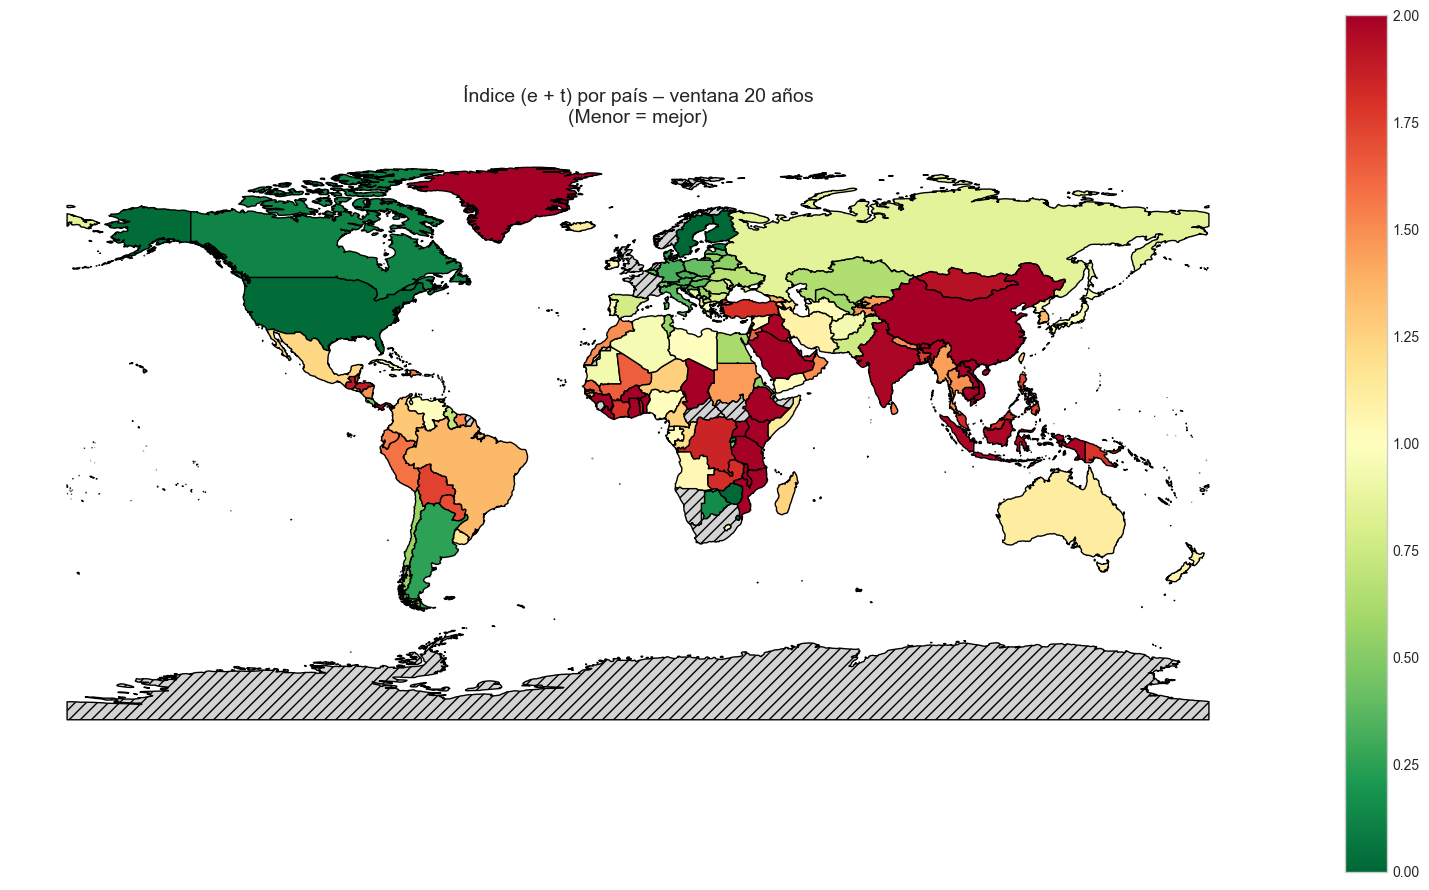

In [5]:
import os
import numpy as np
import pandas as pd
import pymysql
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry

# ==========
# Parámetros
# ==========
N = 20          # ventana de años
CLIP = True     # recortar componentes a [0,1]
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# ==========
# DB connect
# ==========
from dotenv import load_dotenv
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# ==============================
# 1) Traer emisiones y temperatura
# ==============================
query = """
SELECT 
    h.anio,
    p.codigo              AS iso2,
    p.nombre              AS pais_nombre,
    i.codigo              AS indicador_codigo,
    h.valor               AS valor
FROM hechos h
JOIN paises p      ON p.codigo = h.pais_id
JOIN indicadores i ON i.id = h.indicador_id
WHERE i.codigo IN ('emision_co2', 'temperaturas')
"""
df = pd.read_sql(query, conn)

# ==============================
# 2) Pivot: una fila por país-año
# ==============================
df_pivot = df.pivot_table(
    index=["anio", "iso2", "pais_nombre"],
    columns="indicador_codigo",
    values="valor",
    aggfunc="mean"
).reset_index()

# Renombrar a nombres simples
df_pivot.rename(columns={
    "emision_co2": "Emisiones",
    "temperaturas": "Temperatura",
    "anio": "Year"
}, inplace=True)

# Nos quedamos con años donde existan ambos indicadores
df_pivot = df_pivot.dropna(subset=["Emisiones", "Temperatura"])

# ==============================
# 3) Función de score por país
# ==============================
def clip01(x):
    return max(0.0, min(1.0, x))

def score_pais(g):
    y_end = g["Year"].max()
    y_start = y_end - (N - 1)
    g_win = g[g["Year"].between(y_start, y_end)]

    # Requiere ambos extremos
    if not ((g_win["Year"] == y_start).any() and (g_win["Year"] == y_end).any()):
        return pd.Series({"Score": np.nan, "YearStart": y_start, "YearEnd": y_end})

    E0 = g_win.loc[g_win["Year"] == y_start, "Emisiones"].mean()
    E1 = g_win.loc[g_win["Year"] == y_end,   "Emisiones"].mean()
    T0 = g_win.loc[g_win["Year"] == y_start, "Temperatura"].mean()
    T1 = g_win.loc[g_win["Year"] == y_end,   "Temperatura"].mean()

    # Validaciones simples
    if E0 is None or T0 is None or pd.isna(E0) or pd.isna(T0) or E0 == 0 or T0 == 0:
        return pd.Series({"Score": np.nan, "YearStart": y_start, "YearEnd": y_end})

    # % variación en fracción (equivalente a %/100)
    e = (E1 - E0) / E0
    t = (T1 - T0) / T0

    if CLIP:
        e = clip01(e)
        t = clip01(t)

    score = e + t   # ambos "malos"; menor = mejor
    return pd.Series({"Score": score, "YearStart": y_start, "YearEnd": y_end})

df_scores = (
    df_pivot
    .groupby(["iso2", "pais_nombre"], as_index=False)
    .apply(score_pais)
)

# También en 0..100 si te resulta más cómodo en dashboards
df_scores["Score_0_100"] = 50 * df_scores["Score"]  # (0..2) -> (0..100)

# ==============================
# 4) Preparar para mapa (ISO2 -> ISO3)
# ==============================
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_scores["iso_a3"] = df_scores["iso2"].apply(iso2_to_iso3)
df_scores = df_scores[df_scores["iso_a3"].notna()].copy()

# Guardar CSV (útil para Power BI)
out_csv = "./scores_pais.csv"
df_scores.to_csv(out_csv, index=False)
print(f"Scores guardados en: {out_csv}")

# ==============================
# 5) Mapa mundial
# ==============================
world = gpd.read_file(SHAPEFILE)
map_data = world.merge(df_scores, left_on="ISO_A3", right_on="iso_a3", how="left")

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(f"Índice (e + t) por país – ventana {N} años\n(Menor = mejor)", pad=12)

# Importante: no forzar paleta ni estilos (dejar por defecto)
map_data.plot(
    column="Score",           # 0..2
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",          # rojo=mal, verde=ok
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"},
)

ax.axis("off")
plt.tight_layout()
plt.show()
